<a href="https://colab.research.google.com/github/potuu/BreastCancerPredictionFromTissue/blob/main/BreastCancerFromTissue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
kaggle datasets download -d farhanmonsur/breast-cancer-split-dataset

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download -d farhanmonsur/breast-cancer-split-dataset

Dataset URL: https://www.kaggle.com/datasets/farhanmonsur/breast-cancer-split-dataset
License(s): unknown
 99% 1.54G/1.55G [00:22<00:00, 94.1MB/s]
100% 1.55G/1.55G [00:22<00:00, 75.3MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/breast-cancer-split-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [12]:
extract_dir='/content/All Data Split'
train_dir=os.path.join(extract_dir,'/content/All Data Split/Train')
test_dir=os.path.join(extract_dir,'/content/All Data Split/Train')

In [59]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,         # Görüntüyü yeniden ölçeklendirir(daha küçük ölçekli verilerle çalışmak daha etkilidir)
    # rotation_range=45,      # Görüntüleri rastgele olarak 0-45 derece aralığında döndürür.(model farklı açılarda görüntülerle karşılaştığında da doğru tahmin yapma yüzdesini artırır)
    #width_shift_range=0.2,   # Görüntüyü yatay olarak ½20 orannında rastgele kaydırır.(nesnelerin görüntüde farklı yerlerde bulunmasına karşı dayanıklılığı sağlar)
    #height_shift_range=0.2,  # Görüntüyü dikey olarak ½20 oranında rastgele kaydırır.(model, dikey kaymalara karşı dayanıklılık geliştirir)
    shear_range=0.2,          # Görüntüyü kayma işlemine tabi tutar, kayma işlemi, görüntünün bir eksen boyunca eğilmesini sağlar.
    #zoom_range=0.2,          # Görütüyü rastgele olarak ½20 oranında yakınlaştırır veya uzaklaştırır
    horizontal_flip=True,     # Görüntüyü rasgele olarak yatay çevirir. Simetrik görüntülerin tanınma yeteneğini artırır
    #fill_mode='nearest'      # Döndürme ya da kaydırma gibi dönüşümler sonucu oluşan boş alanları en yakın piksel renkleri ile doldurur
)

# Test verilerini yeniden ölçeklendirilmesi
test_datagen = ImageDataGenerator(rescale=1./255)

eğitim verilerinin yüklenmesi

In [60]:
# yukarıda tanımladığımız train_datagen() nesnesini alıyoruz, ImageDataGenerator'un bir sınıfı olan flow_from_directory() fonksiyonu ile belirli bir önişlemeye tabi tutuyoruz.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64), # 150*150 piksellik olarak yeniden boyutlandırıyoruz
    batch_size=128,          # Her seferinde 128'lik gruplar olacak şekilde yüklüyoruz. Ram kullanımında verimlilik sağlar.(Daha iyi model tahmini için boyutu 64 ve 32 olarak azaltabiliriz)
    class_mode='binary'     # Sınıflandırmanı iki olduğunu modele belirtiyoruz, sonuç olarak sadece 0 ve 1 durumları vardır. Örnek olarak cevap, ya siyahtır ya da beyazdır.
)

Found 212421 images belonging to 2 classes.


**test verilerinin yüklenmesi**

In [61]:
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(64,64),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Found 212421 images belonging to 2 classes.


# **CNN modelinin oluşturulması**

---
Görüntüyü alıp, işleyerek ikili sınıflandırma için bir tahmin yapar. CNN ile görüntüden özellikler çıkarır ve bunları kullanarak ikili sınıflandırma yapar.


In [62]:
# Keras
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # 150*150 boyutunda bir veriyi alır, relu ile negatif değerleri sıfırlayıp pozitif değerleri olduğu gibi geçirir(Doğrusal olmayan ilişkiyi sağlar) 32 kernel(filtre) uygular ve (3,3) boyutunda bir veridir.
    MaxPooling2D(2, 2),
    # Max-pooling, 2*2 alandaki en yüksek değeri seçerek görüntü boyutunu yarıya indirir.(Hesaplama maaliyetini düşürür ve önemli özellikleri korur)
    Conv2D(64, (3, 3), activation='relu'),
    # İkinci evrişim katmanı, önceki ile aynı mantıkla çalışır ancak 64 filtre kullanarak daha fazla özellik çıkarımı sağlar.
    MaxPooling2D(2, 2),
    # İkinci max-pooling katmanı, boyutu tekrar yarıya indirir.
    Flatten(),
    # Çok boyutlu çıktıları tek boyutlu bir vektöre dönüştürür(Böylece veriler, tam bağlantılı katmana(dense layer) beslenebilir)
    Dense(64, activation='relu'),
    # Tam bağlantılı katman, 64 nöronlu bir katmandır.(Daha iyi tahmin için nöron sayını 128 olarak ayarlayabiliriz) Program 12544 kullanmaya mecbur etti beni(?)
    Dropout(0.5),
    # Overfitting(aşırı öğrenme) sorununu azaltmak için rasgele olarak nöronları ½50 oranında devre dışı bırakır.
    Dense(1, activation='sigmoid')
    # Çıkış katmanıdır, yalnızca 1 nörona sahiptir(şu anki beynim gibi) sigmoid aktivasyonu funksiyonunu kullanır.(Sigmoid fonksiyonu, çıktıyı 0 ile 1 arasında bir değere sıkıştırır, bu da ikili sınıflandırma için kullanılır)
])

**Compile**

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Adaptive Moment Estimation algoritması, even I can't understand actually lol
# binary_crossentropy modelin tahmin ettiği çıktı ile gerçek çıktı arasındaki farkı ölçer
# accuracy ise modelin doğruluğunu ölçer

# **Modelin eğitilmesi** **6 SAAT 17 DAKİKA SÜRDÜ**

In [64]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Modelin doğrulama doğrulu iyileşmediği durumlarda eğitimi durdurma

history = model.fit(
    train_generator,
    #eğitim verilerini sağlayan veri üreteçi olarak kullanılır
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    # .samples toplam eğitim örneği sayısını, .batch_size her adımda işlenecek örnek sayısını ifade eder
    epochs=5, # epochs=10,
    # Tüm eğitim verilerinin üzerinden kaç kez geçileceğini belirliyoruz
    validation_data=test_generator,
    # Her epoch sonrasında test_generator(doğrulama verilerini sağlayan veri üreteci olarak kullanılır) verilerini kullanarak test edilmesini sağlar
    validation_steps=test_generator.samples // test_generator.batch_size
    # her epoc sonrasında kaç adım yapılacağını belirler. .samples toplam doğrulama örneği sayısını, .batch_size ise her adımda işlenecek örnek sayısını ifade eder
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1659/1659 ━━━━━━━━━━━━━━━━━━━━ 2051s 1s/step - accuracy: 0.7151 - loss: 4.6034 - val_accuracy: 0.7226 - val_loss: 0.6489
Epoch 2/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 1s 137us/step - accuracy: 0.7266 - loss: 0.4807 - val_accuracy: 0.0000e+00 - val_loss: 0.8133
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1659/1659 ━━━━━━━━━━━━━━━━━━━━ 2013s 1s/step - accuracy: 0.7234 - loss: 0.5064 - val_accuracy: 0.7226 - val_loss: 0.6578
Epoch 4/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 1s 79us/step - accuracy: 0.7266 - loss: 0.4257 - val_accuracy: 0.0000e+00 - val_loss: 0.7846
Epoch 5/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 2070s 1s/step - accuracy: 0.7223 - loss: 0.4790 - val_accuracy: 0.7226 - val_loss: 0.6845


**Eğitim ve doğrulama doğruluğu grafiği**

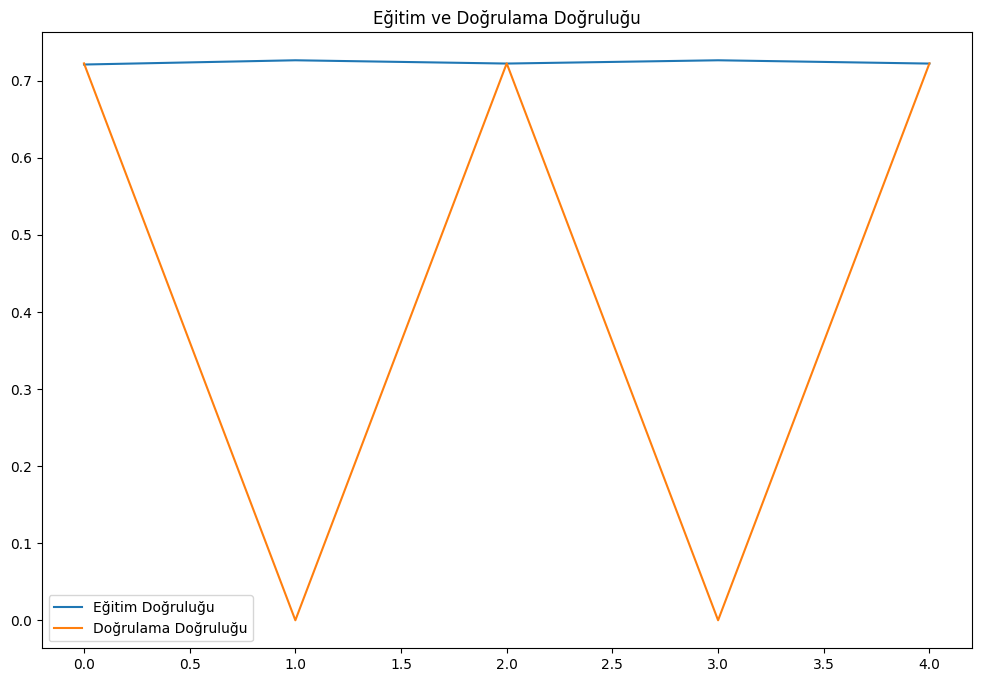

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

**Eğitim ve doğrulama kaybı grafiği**

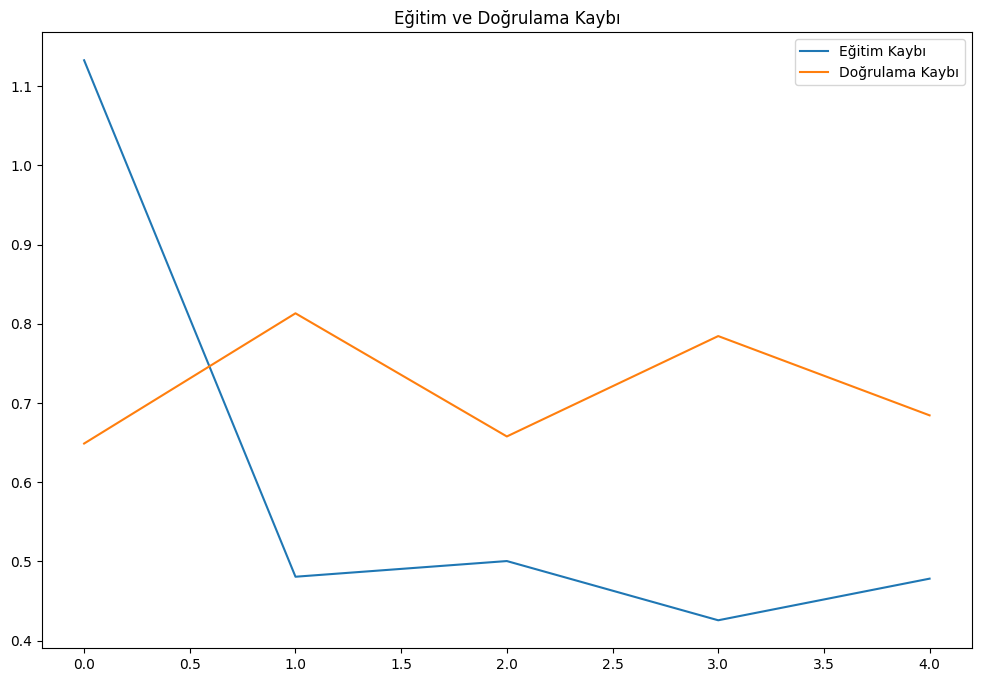

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.show()

# **Modelin tahmin yapması ve doğruluğunun hesaplanması**

In [67]:
Y_pred = model.predict(test_generator)
# Eğitimde kullanılan test_generator ile model üzerinde tahminler yapar
y_pred = np.where(Y_pred > 0.5, 1, 0)
# koşul sağlanıyorsa 1, sağlanmıyorsa 0 olarak tanımla, gelen binary değeri predict olarak ata

1660/1660 ━━━━━━━━━━━━━━━━━━━━ 465s 280ms/step


**Confusion Matrix Report**

In [68]:
print('Confussion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
# Tahmin sonuçlarının gerçek etiketleriyle karşılaştırarak bir confusion matris hesaplayıp, yazdırıyoruz

Confussion Matrix
[[153435      0]
 [ 58986      0]]


**Classification Report**

In [69]:
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
# Tahmin performanslarını özetlemek için sınıflandırma raporu üretip çıktısını yazıyoruz

Classification Report


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       0.72      1.00      0.84    153435
   Malignant       0.00      0.00      0.00     58986

    accuracy                           0.72    212421
   macro avg       0.36      0.50      0.42    212421
weighted avg       0.52      0.72      0.61    212421



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Doğruluk oranı (accuracy) hesaplama**

In [70]:
accuracy=accuracy_score(test_generator.classes, y_pred)
print(f"Modelin doğruluk oranı: ½{accuracy *100:.2f}")
# Ne kadar doğru tahminler yaptığımızı anlamamıza imkan sağlar, genel başarıyı değerlendirmek için kullanılır

Modelin doğruluk oranı: ½72.23


**görüntülerin bölünmesi ve analiz edilmesi**

In [71]:
import random
from keras.preprocessing.image import load_img,img_to_array

tahmin sırasında görüntülerin bölünmesi ve analiz edilmesi

In [73]:
img_path=os.path.join(test_dir,'1', random.choice(os.listdir(os.path.join(test_dir,'1'))))
# rastgele bir görüntü yolu seç

def predict_image_with_augmentation(image_path):
    # Görüntüyü ekle ve ön işlemleri yap
    img=load_img(image_path,target_size=(150,150))
    img=img_to_array(img) / 255.0
    img=np.expand_dims(img, axis=0)

    # Augmentation işlemleri
    img_gen=test_datagen.flow(img,batch_size=1)

    for i in range(5):
      aug_img=next(img_gen)[0]
      plt.imshow(aug_img)
      plt.axis('off')
      plt.show()

      # Tahmin yap
      pred=model.predict(np.expand_dims(aug_img,axis=0))
      if pred>=0.5:
        print(f"Model Tahmini: Kanserli(Confidence: {pred[0][0]:.2f})")
      else:
        print(f"Model Tahmini: Kansersiz(Confidence: {1-pred[0][0]:.2f})")


In [74]:
predict_image_with_augmentation(random_img_path)

NameError: name 'random_img_path' is not defined